In [52]:
import numpy as np
from numpy.random import random
import matplotlib.pyplot as plt
import numpy
from os import listdir

In [51]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [53]:
%%cython
import numpy as np
cimport numpy as np

def calculate_3d_velocity( np.float64_t beta, int Nx, int Ny, int Nz  ):
    
    
    cdef np.ndarray[np.float64_t, ndim = 1] kx, ky, kz
    cdef np.ndarray[np.float64_t, ndim = 3] Amp_K, phase3d, kx3d,ky3d,kz3d, Rk
    cdef np.ndarray[np.complex128_t, ndim = 3] V_x
    
    kx = np.fft.fftfreq( Nx, d = 1.0/Nx ) 
    ky = np.fft.fftfreq( Ny, d = 1.0/Ny ) 
    kz = np.fft.fftfreq( Nz, d = 1.0/Nz ) 
    
    # just to prevent the 1 / 0 error
    # no physical meaning
    kx[0] = kx[1]*0.001
    ky[0] = ky[1]*0.001
    kz[0] = kz[1]*0.001

    Amp_K = np.zeros((Nx,Ny,Nz))
    phase3d = np.random.random((Nx,Ny,Nz)) * 3.14159 * 2.0
    
    kx3d,ky3d,kz3d = np.meshgrid(kx,ky,kz)
    
    Rk = np.sqrt( kx3d*kx3d + ky3d*ky3d + kz3d*kz3d )
    Amp_K = Rk**( (- beta - 2.0)/2.0 ) * np.cos(phase3d)
    
    # this corresponds to the kmin
    cdef double kmin = 3.0
    Amp_K[Rk < kmin] = 0.0
    
    # normalize the Amp_K by the average dispersion
    Vdisp = np.ones( (Nx,Ny,Nz) )*np.sqrt( kmin**(-beta + 1) / (beta - 1.0) )
    Amp_K = Amp_K / Vdisp
    
    V_x = np.fft.fftn(Amp_K)
    
    return V_x

In [54]:
def caculate_power_spectrum(V_x):
    
    Pk3d = numpy.abs(numpy.fft.fftn(V_x))**2.0
    
    Nx, Ny, Nz = Pk3d.shape
    
    kx = np.fft.fftfreq( Nx, d = 1.0/Nx ) 
    ky = np.fft.fftfreq( Ny, d = 1.0/Ny ) 
    kz = np.fft.fftfreq( Nz, d = 1.0/Nz )     
    kx3d,ky3d,kz3d = np.meshgrid(kx,ky,kz)
    
    Rk = np.sqrt( kx3d*kx3d + ky3d*ky3d + kz3d*kz3d )
    
    Rkbins = 128
    bins   = np.linspace( np.min(Rk), np.max(Rk), Rkbins )
    dbins  = bins[1] - bins[0]
    
    Pk_kR = []
    for i in range(Rkbins):
        kbin = bins[i]

        iloc = numpy.logical_and( (Rk > kbin) , (Rk < kbin+dbins) )
        Pk_kR.append( Pk3d[iloc].sum() )
    
    
    return bins, Pk_kR


def convert_to_PPV( V , Nx, Ny, Nv, vmin = -5.0, vmax = 5.0 ):
    ppv = numpy.zeros((Nx,Ny,Nv))
    bins = numpy.linspace( vmin, vmax ,  Nv + 1)

    for i in range(Nx):
        for j in range(Ny):
            count, _ = numpy.histogram(V[i,j,:], bins = bins)
            ppv[i,j,:] = count.astype('float32')
    return ppv


In [59]:
beta_range = numpy.linspace(1.1 , 4.0, 4)


Nv = 128
NX = 512
NY = 512
NZ = 512


all_kbin = []
all_Pkbin = []
for i in beta_range:
    V_x = calculate_3d_velocity( i, NX, NY, NZ)
    V_x1 = V_x.real - V_x.real.mean()
    kbin, Pkbin = caculate_power_spectrum(V_x)
    all_kbin.append(kbin)
    all_Pkbin.append(Pkbin)

Done with Matrix
Done with Matrix
Done with Matrix
Done with Matrix


-1.063113851791157 actual_beta :1.1
-2.0003385064591943 actual_beta :2.066666666666667
-2.9361107305079153 actual_beta :3.033333333333333
-3.874964787071417 actual_beta :4.0


C:\Users\hiSun\Anaconda3\envs\keras35\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


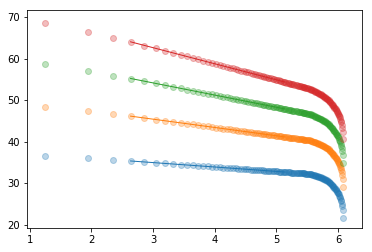

In [69]:
i = 0
for actual_beta in beta_range:
    
    K  = numpy.log( all_kbin [i][4:50] )
    PK = numpy.log( all_Pkbin[i][4:50] )
    
    fitting_result = numpy.polyfit(K, PK,1)
    f = numpy.poly1d(fitting_result)
    print(fitting_result[0], "actual_beta :{}".format(actual_beta) )

    plt.scatter(numpy.log(all_kbin [i]), numpy.log(all_Pkbin[i]) + i*10, alpha=0.3 )
    plt.plot(K,f(K)+ i*10, lw = 1.0)

    i += 1
    


In [70]:
beta_range = numpy.linspace(1.1 , 4.0, 100)

Nv = 128
NX = 512
NY = 512
NZ = 512

for i in beta_range:
    print("getting PPV for beta =  {:0.2f}".format(i))
    V_x = calculate_3d_velocity( i, NX, NY, NZ)
    V_x1 = V_x.real - V_x.real.mean()
    vmin = numpy.min(V_x1)
    vmax = numpy.max(V_x1)
    ppv = convert_to_PPV(V_x1 , NX,NY,Nv, vmin = vmin, vmax = vmax)
    numpy.save( "vdata/{:0.2f}_ppv.npy".format(i), ppv)

getting PPV for beta =  1.10
Done with Matrix
getting PPV for beta =  1.13
Done with Matrix
getting PPV for beta =  1.16
Done with Matrix
getting PPV for beta =  1.19
Done with Matrix
getting PPV for beta =  1.22
Done with Matrix
getting PPV for beta =  1.25
Done with Matrix
getting PPV for beta =  1.28
Done with Matrix
getting PPV for beta =  1.31
Done with Matrix
getting PPV for beta =  1.33
Done with Matrix
getting PPV for beta =  1.36
Done with Matrix
getting PPV for beta =  1.39
Done with Matrix
getting PPV for beta =  1.42
Done with Matrix
getting PPV for beta =  1.45
Done with Matrix
getting PPV for beta =  1.48
Done with Matrix
getting PPV for beta =  1.51
Done with Matrix
getting PPV for beta =  1.54
Done with Matrix
getting PPV for beta =  1.57
Done with Matrix
getting PPV for beta =  1.60
Done with Matrix
getting PPV for beta =  1.63
Done with Matrix
getting PPV for beta =  1.66
Done with Matrix
getting PPV for beta =  1.69
Done with Matrix
getting PPV for beta =  1.72
Done 

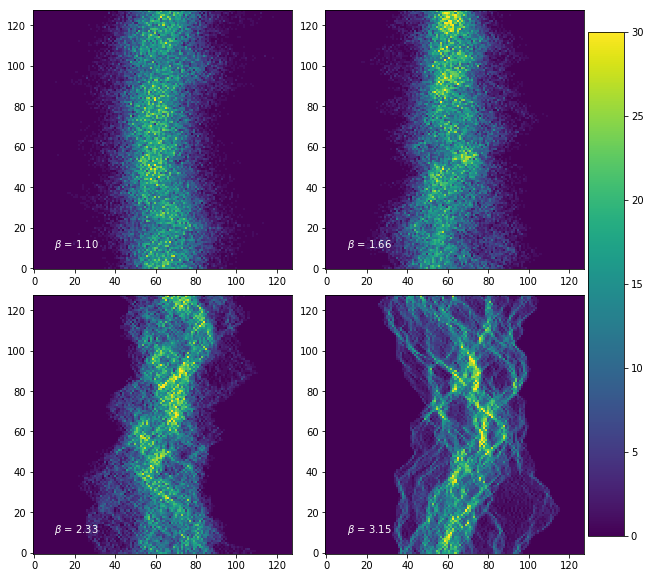

In [43]:


fig, axes = plt.subplots(2, 2 )
fig.set_figheight(10)
fig.set_figwidth(10)
filenames = ["1.10_ppv.npy", "1.66_ppv.npy", "2.33_ppv.npy","3.15_ppv.npy" ]
axis_index = [(0,0),(0,1),(1,0),(1,1)]

for idx, filename in zip(axis_index, filenames):
    ppv = numpy.load('vdata/{}'.format(filename))
    x = numpy.random.randint(0,512)
    y = numpy.random.randint(0,512-128)
    im = axes[idx].imshow( ppv[x, y:y+128,: ], origin='lower', vmin=0, vmax=30 )
    beta = filename.strip('_ppv.npy')
    axes[idx].annotate(r'$\beta$ = '+beta, xy=(10,10) ,color='w'  )

    
fig.subplots_adjust(wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

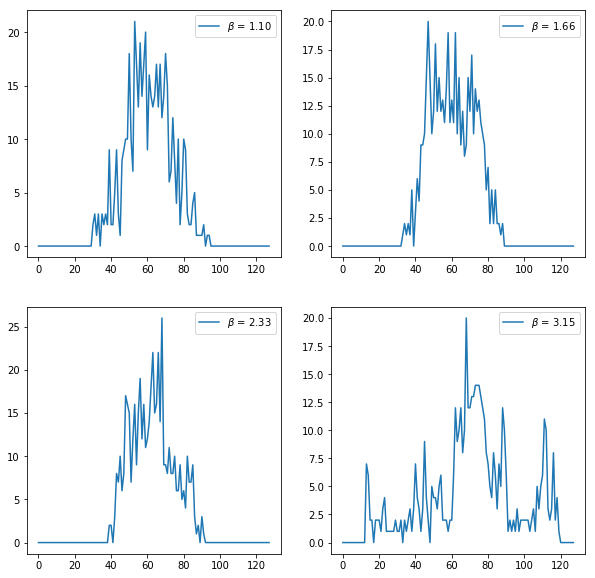

In [45]:
fig, axes = plt.subplots(2, 2 )
fig.set_figheight(10)
fig.set_figwidth(10)
filenames = ["1.10_ppv.npy", "1.66_ppv.npy", "2.33_ppv.npy","3.15_ppv.npy" ]
axis_index = [(0,0),(0,1),(1,0),(1,1)]

for idx, filename in zip(axis_index, filenames):
    ppv = numpy.load('vdata/{}'.format(filename))
    x = numpy.random.randint(0,512)
    y = numpy.random.randint(0,512-128)
    beta = filename.strip('_ppv.npy')
    im = axes[idx].plot( ppv[x, y,: ], label=r'$\beta$ = '+beta )
    axes[idx].legend()